### Get 5 minute data from IB
This requires you starting the IB History server. Use the following bash command:
1. cd ~/
2. bash launch_ibhist.sh
3. this command will navigate to /Dropbox/Jrtr/deployment_3_0/MeteorLaunch and launch another .sh file.



In [12]:
import pandas as pd
import numpy as np
from dash.dependencies import Input, Output, State
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import datetime
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import os,sys
import importlib
import plot_utilities as pu
import math

## Set important parameters here.
### Reset ```REFETCH_IB``` to ```True``` if you want to re-fetch data from IB

In [13]:

REFETCH_IB = False
SAVE_BASE = !echo $(cd ~;pwd)
SAVE_BASE = f'{SAVE_BASE[0]}/dropbox/market_data/futures'
SAVE_BASE

'/Users/bperlman1/dropbox/market_data/futures'

### If REFETCH_IB == True, then fetch 5 minute bars from the IB History server that you ran from your console using the instructions above.

In [14]:
# fetch history from history server
def get_ib_futures_hist(contract,num_mins=5,days_to_fetch=120):
    n = datetime.datetime.now()    
    yyyy = n.year
    m = n.month
    t = datetime.datetime(yyyy,m,1)
    months_back = math.floor(max(0,(n-t).days/30))
    yyyymm_now = yyyy*100 + m
    parts = contract.split('.')
    yyyymm_contract = int(parts[4])
    mills = 60000 * num_mins
    h = f"http://127.0.0.1:8899/ibhistory?{mills}%20{days_to_fetch}%20{months_back}%20{num_mins}%20{contract}"
    print(h)
    df = pd.read_csv(h)
    return df


### Set the variables ```co``` and ```exch``` to a contract and exchange values like:
1. ZS and ECBOT, or 
2. CL and NYMEX

In [15]:
co = 'ZS'
exch = 'ECBOT'
yyyymms = [201801,201803,201805,201807,201808,201809,201811,201901,201903,201905,201907]
clist = [f'{co}.FUT.{exch}.USD.{yyyymm}' for yyyymm in yyyymms]
clist

['ZS.FUT.ECBOT.USD.201801',
 'ZS.FUT.ECBOT.USD.201803',
 'ZS.FUT.ECBOT.USD.201805',
 'ZS.FUT.ECBOT.USD.201807',
 'ZS.FUT.ECBOT.USD.201808',
 'ZS.FUT.ECBOT.USD.201809',
 'ZS.FUT.ECBOT.USD.201811',
 'ZS.FUT.ECBOT.USD.201901',
 'ZS.FUT.ECBOT.USD.201903',
 'ZS.FUT.ECBOT.USD.201905',
 'ZS.FUT.ECBOT.USD.201907']

In [16]:
if REFETCH_IB:
    dict_df = {}
    for c in clist:
        dict_df[c] = get_ib_futures_hist(c)
        dict_df[c].to_csv(f'{SAVE_BASE}/{co}/{c}.csv',index=False)


### Use the data to graph things of interest

In [17]:
fnames = sorted([fn for fn in os.listdir(f'{SAVE_BASE}/{co}') if co in f'{fn}.'])# 
fnames

['ZS.FUT.ECBOT.USD.201801.csv',
 'ZS.FUT.ECBOT.USD.201803.csv',
 'ZS.FUT.ECBOT.USD.201805.csv',
 'ZS.FUT.ECBOT.USD.201807.csv',
 'ZS.FUT.ECBOT.USD.201808.csv',
 'ZS.FUT.ECBOT.USD.201809.csv',
 'ZS.FUT.ECBOT.USD.201811.csv',
 'ZS.FUT.ECBOT.USD.201901.csv',
 'ZS.FUT.ECBOT.USD.201903.csv',
 'ZS.FUT.ECBOT.USD.201905.csv',
 'ZS.FUT.ECBOT.USD.201907.csv']

### Create  important date columns 
These columns help you scale the 5 minute bars to a longer minute length, like 15, 30 or 60 minutes, or one whole day

In [18]:
def get_date_cols(df,rts_end_hhmm):
    '''
    Create a new DataFrame with columns:
        year,month,day,hour,minute,dt,hhmm,isnextday,trade_date
    '''
    df2 = df.copy()
    df2['date_str'] =df2.date.astype(str)
    df2['year'] = df2.date_str.str.slice(0,4).astype(int) 
    df2['month'] = df2.date_str.str.slice(4,6).astype(int)  
    df2['day'] = df2.date_str.str.slice(6,8).astype(int)  
    df2['hour'] = df2.date_str.str.slice(8,10) .astype(int) 
    df2['minute'] = df2.date_str.str.slice(10,12) .astype(int)
    z = zip(df2.year,df2.month,df2.day,df2.hour,df2.minute)
    df2['dt'] = [datetime.datetime(x[0],x[1],x[2],x[3],x[4]) for x in z ]
    df2['hhmm'] = df2.date_str.str.slice(8,12)
    df2['isnextday'] = df2.hhmm > rts_end_hhmm
    z = zip(df2.dt,df2.isnextday.astype(int))
    df2['trade_date'] = [x[0] + datetime.timedelta(x[1]) for x in z]
    df2.trade_date = df2.trade_date.astype(str).str.replace('-','').str.slice(0,8)
    return df2

### Define a method to rescale csv files for a specific commodity's from 5 minute data to a "less granular" bar size, like 30 minute bars.

In [19]:
def scale_intraday(df,minute_scale,end_hhmm='1430'):
    scale_functions = {'adjusted':'last','close':'last', 'high':'max','low':'min', 
                       'open':'first', 'volume':'sum','execute_date':'first'}    

    df2 = df.copy()
    df3 = get_date_cols(df2,end_hhmm)
    def _get_hhmm_rescaled(hhmm,minute_scale):
        p1 = str(hhmm)[:2]
        p2 = int(str(hhmm)[-2:])
        p2 = int(p2/minute_scale) * minute_scale
        p2 = '%02d'%(p2)
        p = p1+p2
        return int(p)

    df3['hhmm_rescaled'] = ['%04d' %(_get_hhmm_rescaled(s,30)) for s in df3.hhmm]
    df3['execute_date'] = df3.date.astype(str).str.slice(0,8)
    df4 = df3[['trade_date','hhmm_rescaled','execute_date','shortName','open','high','low','close','volume','adjusted']]
    df4_scaled = df4.groupby(['trade_date','hhmm_rescaled'],as_index=False).agg(scale_functions)
    df4_scaled['date'] = df4_scaled.execute_date + df4_scaled.hhmm_rescaled + '00'
    df4_scaled = df4_scaled.sort_values('date')
    df5_scaled = get_date_cols(df4_scaled,end_hhmm)
    df5_scaled
    return df5_scaled


### Define a method to rescale 5 minute bars to daily bars

In [20]:
def scale_daily(df,hhmm_for_open):
    scale_functions = {'adjusted':'last','close':'last', 'high':'max','low':'min', 
                       'daily_open':'mean', 'volume':'sum'}    
    df2 = get_date_cols(df,'1430')
    df2_open = df2[df2.hhmm==hhmm_for_open][['trade_date','open']]
    df2_open = df2_open.rename(columns={'open':'daily_open'})
    df3 = df2.merge(df2_open,how='inner',on='trade_date')
    df3 = df3[['trade_date','shortName','daily_open','high','low','close','volume','adjusted']]
    df4_scaled = df3.groupby('trade_date',as_index=False).agg(scale_functions)
    df4_scaled['date'] = [int(s  + '000000') for s in df4_scaled.trade_date.astype(str)]
    df4_scaled = df4_scaled.rename(columns={'daily_open':'open'})
    df4_scaled = get_date_cols(df4_scaled,'1430')
    return df4_scaled

### Compare daily and intra day data
Loop through sets of days for a specific contract, and print:
1. The daily bars
2. The intraday bars

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



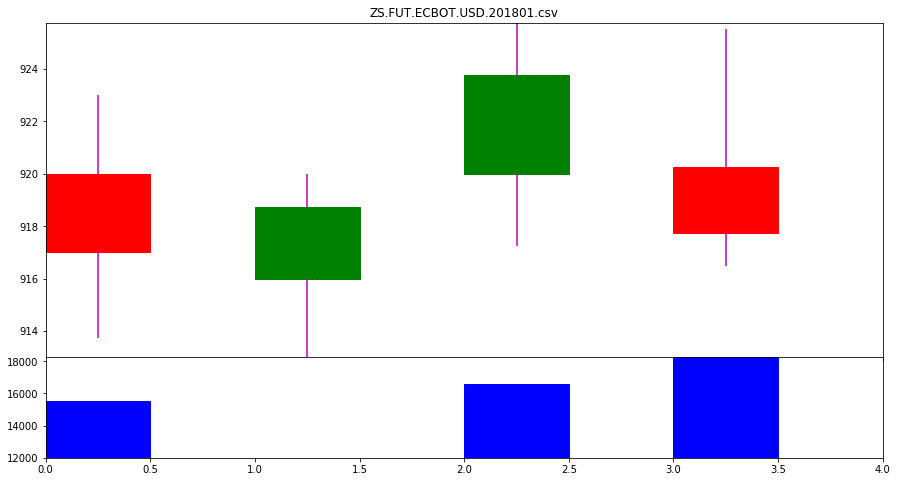

<Figure size 432x288 with 0 Axes>

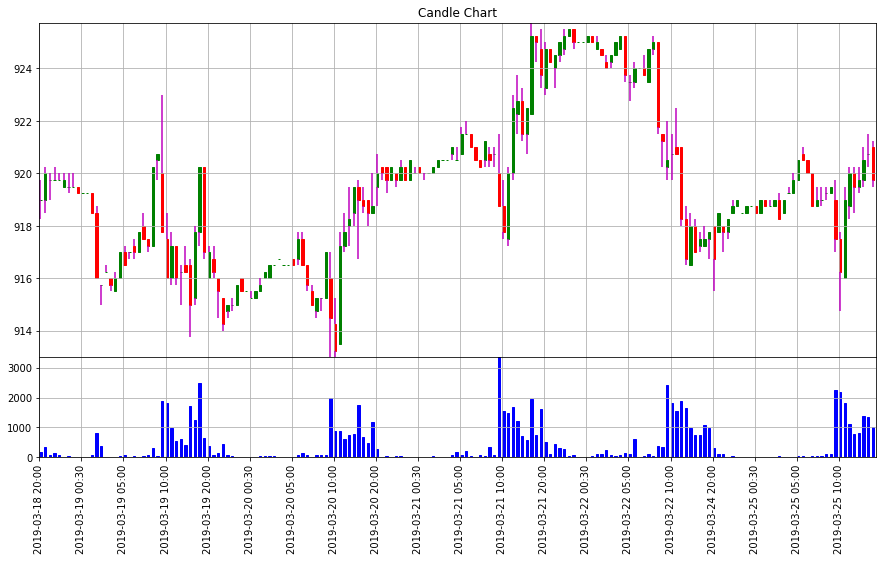

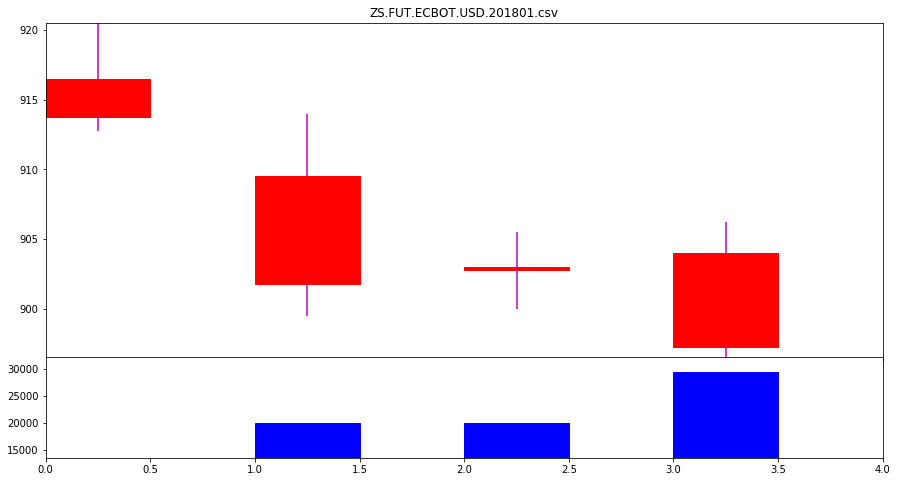

<Figure size 432x288 with 0 Axes>

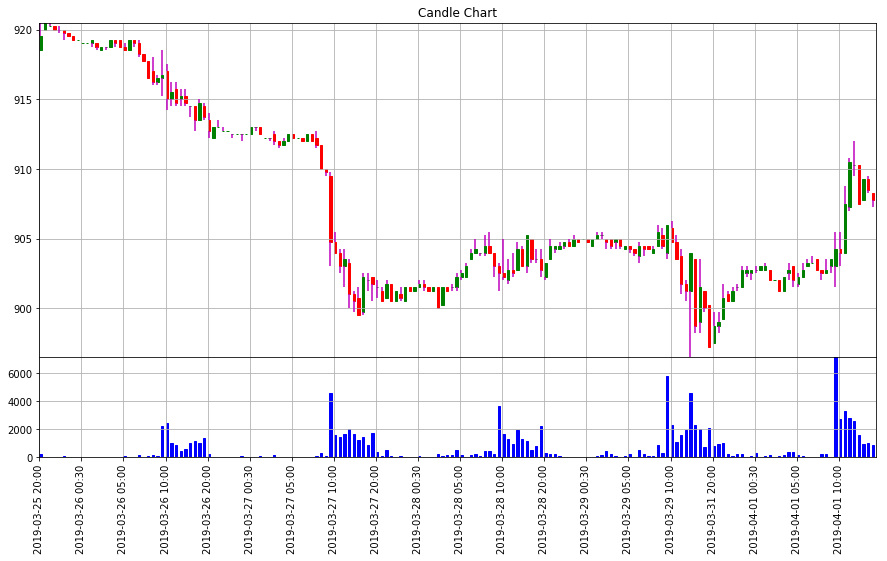

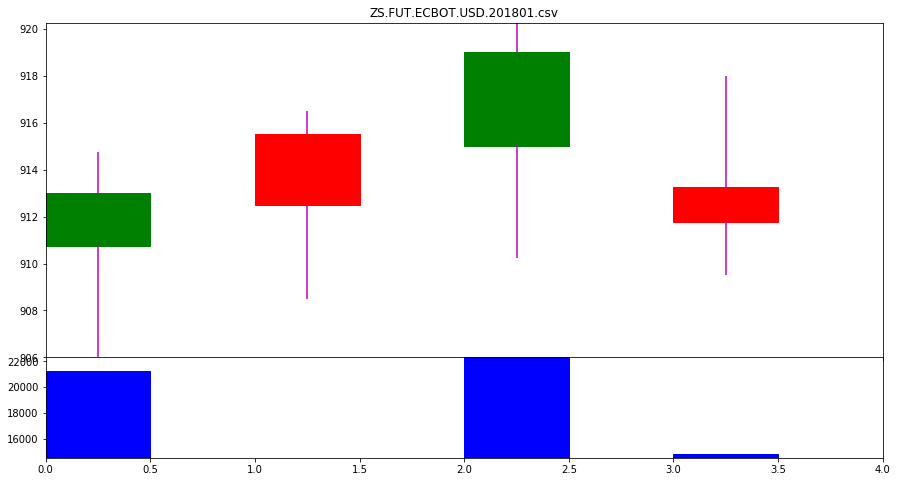

<Figure size 432x288 with 0 Axes>

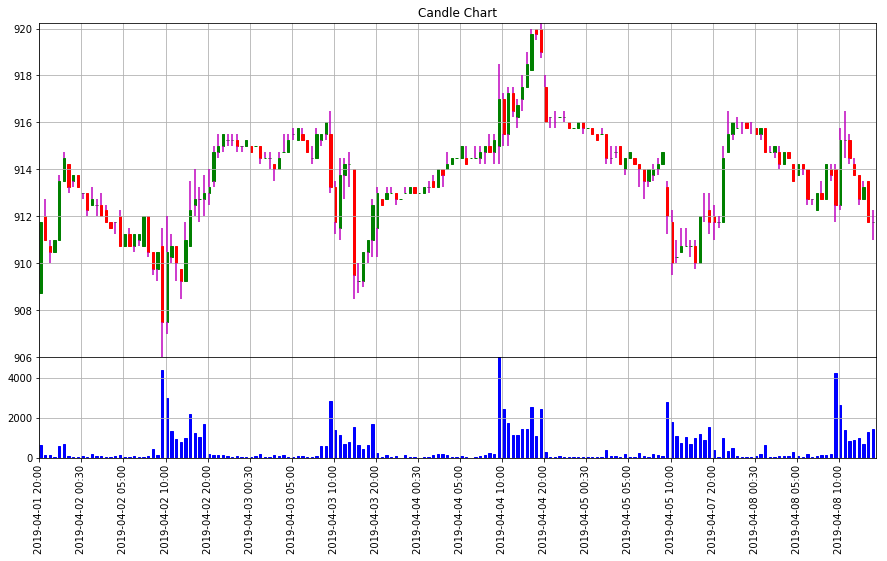

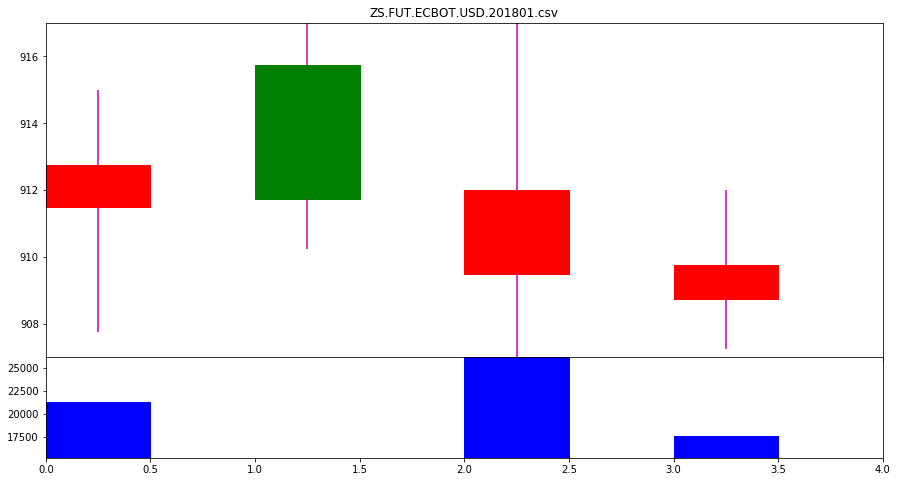

<Figure size 432x288 with 0 Axes>

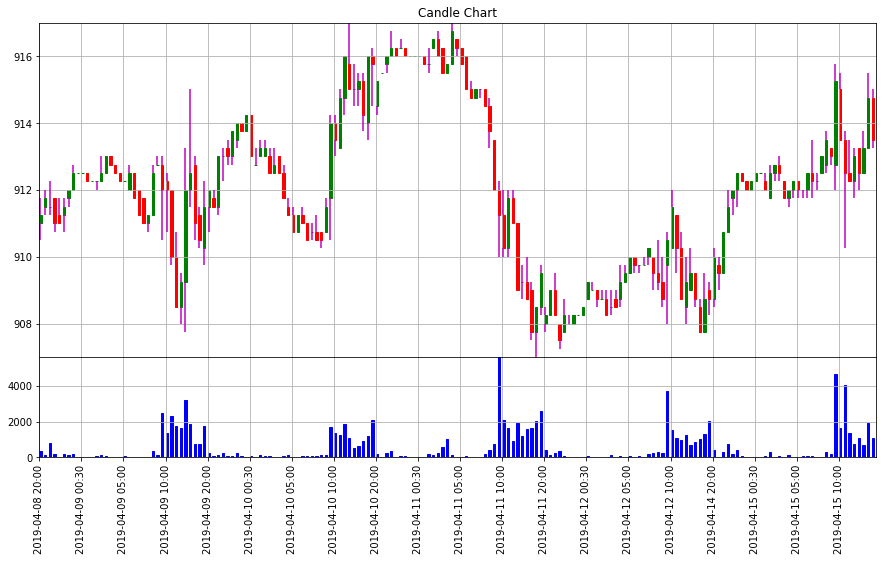

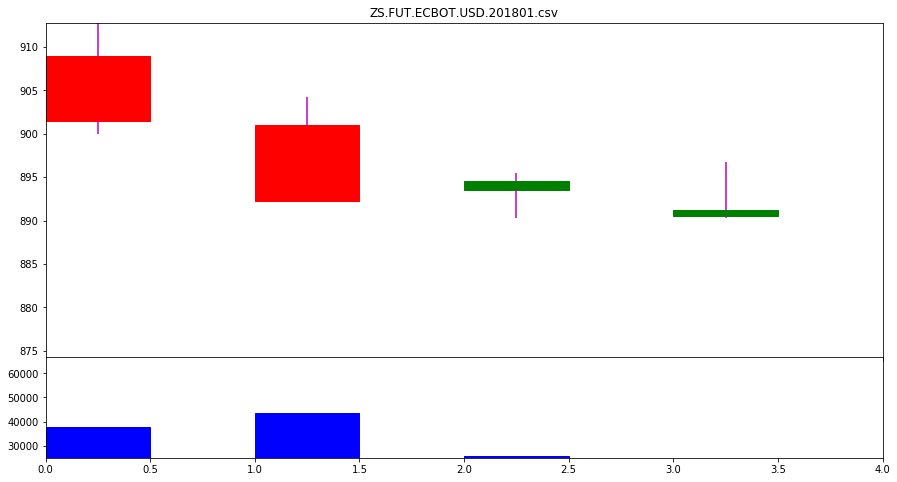

<Figure size 432x288 with 0 Axes>

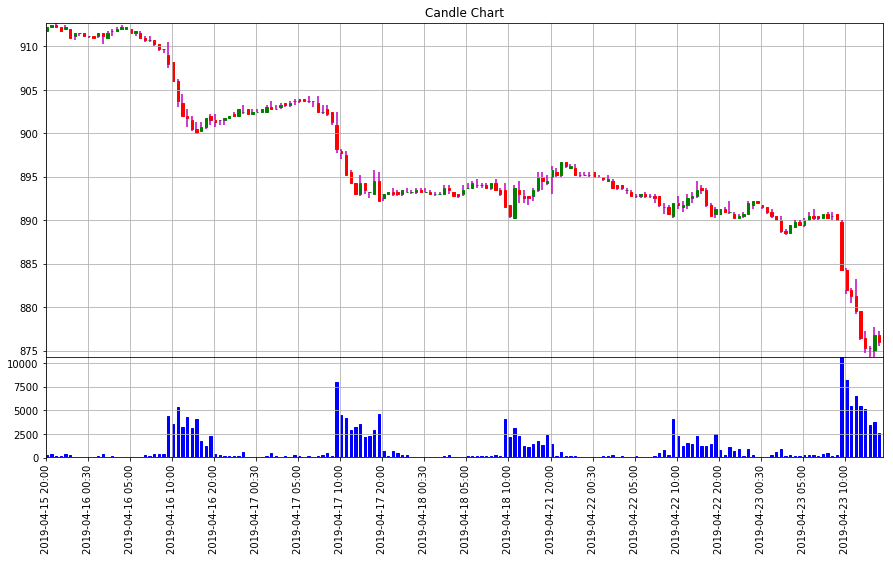

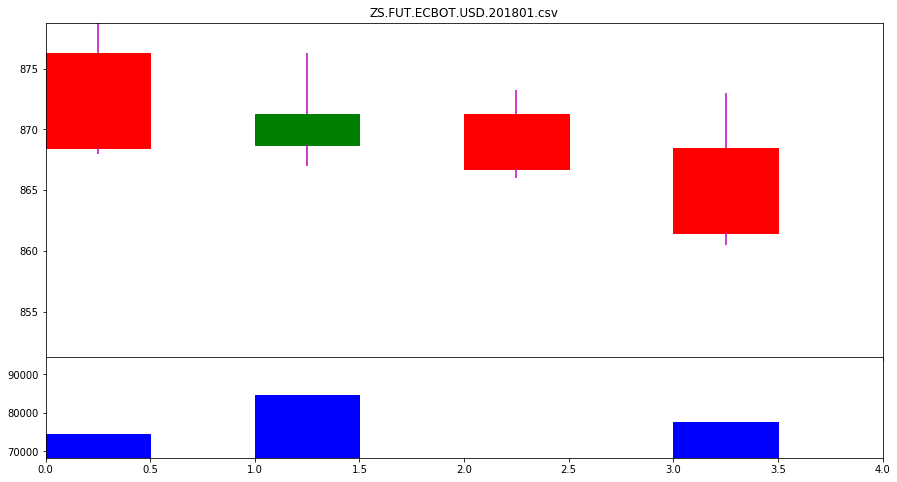

<Figure size 432x288 with 0 Axes>

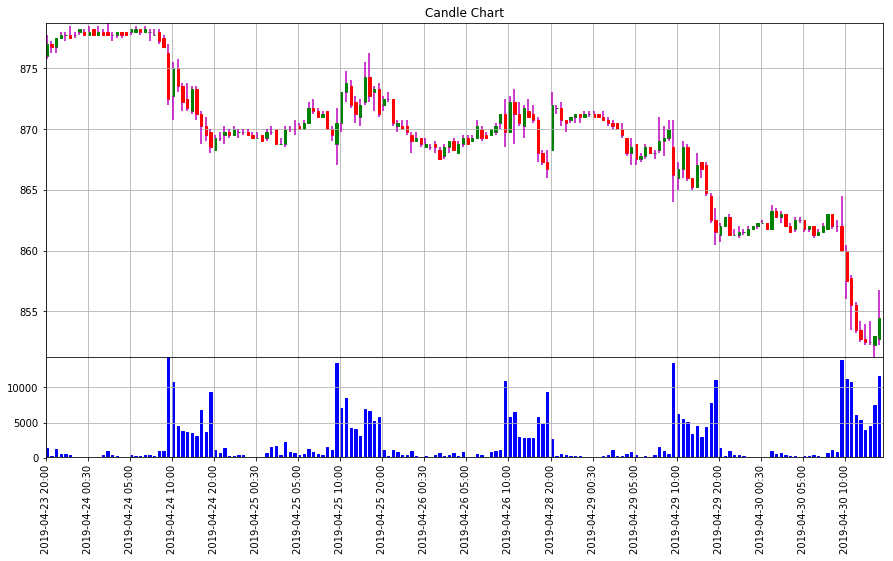

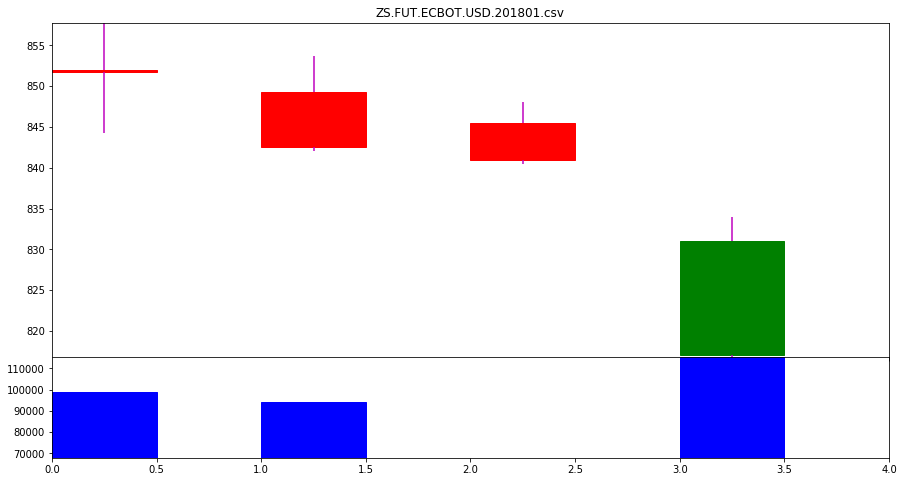

<Figure size 432x288 with 0 Axes>

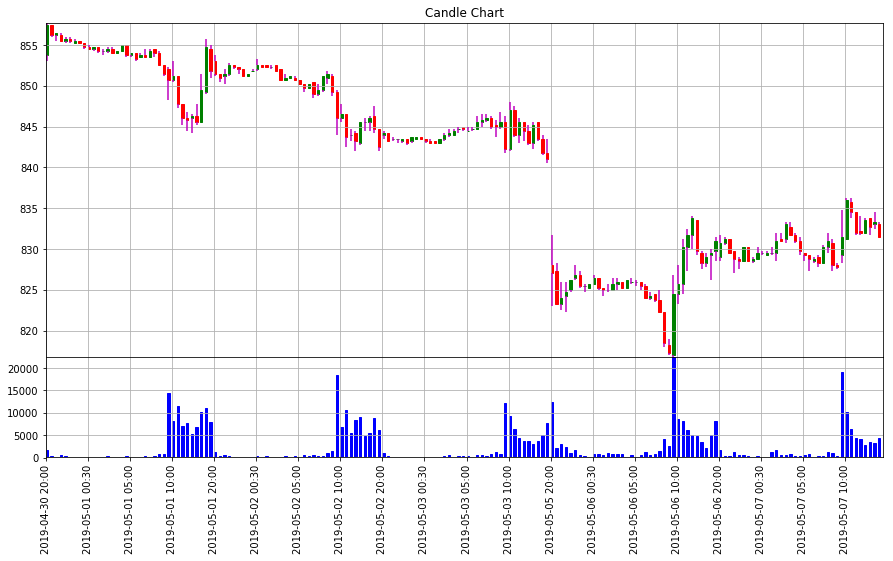

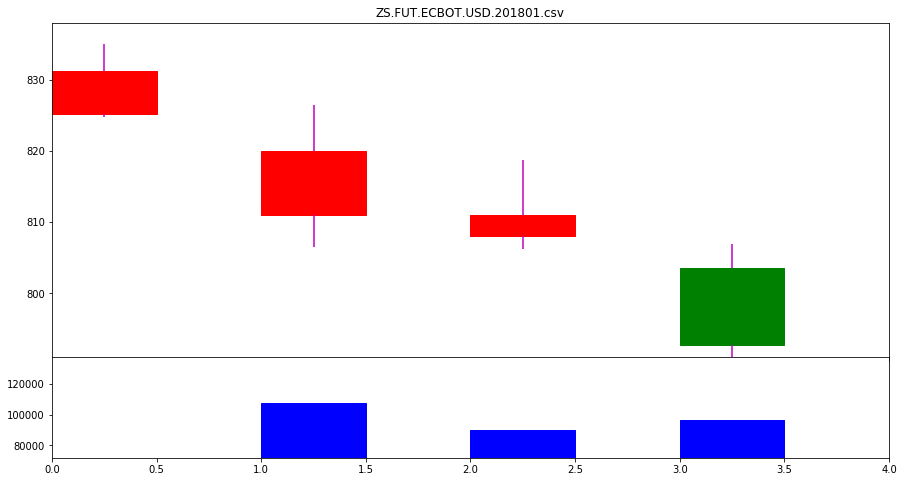

<Figure size 432x288 with 0 Axes>

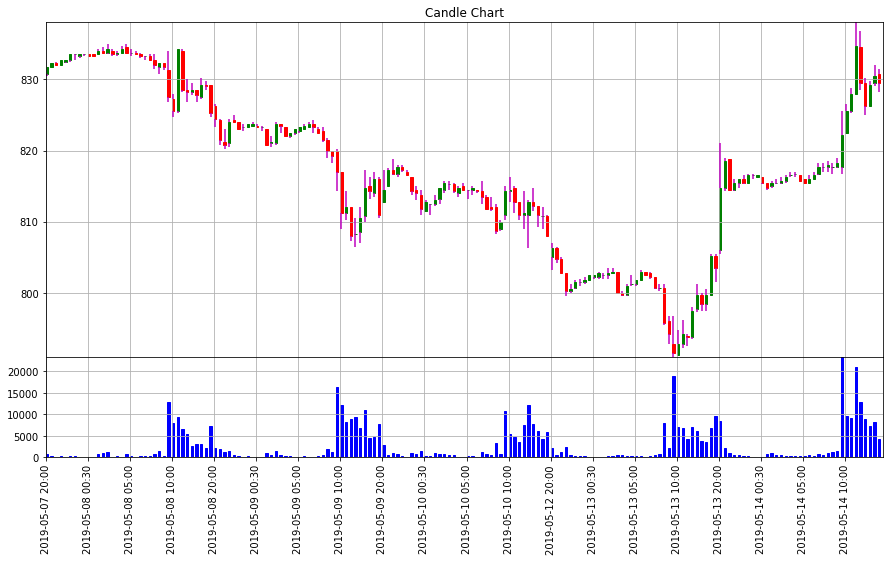

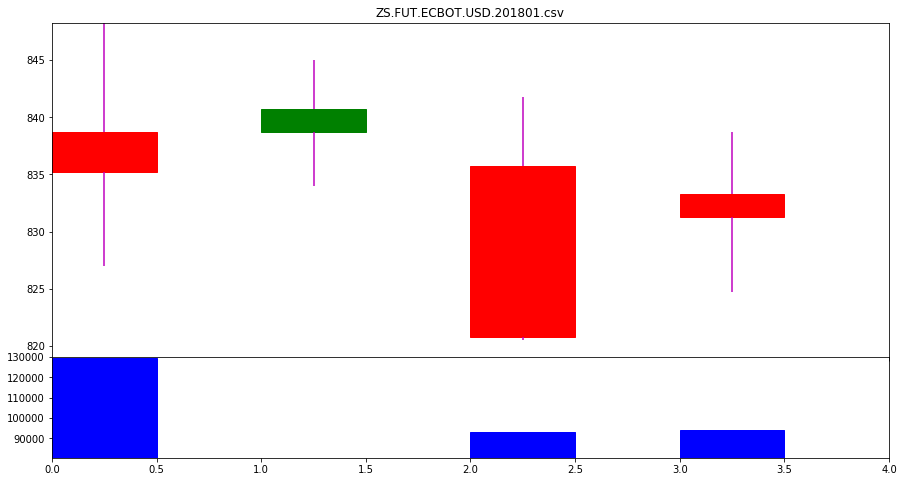

<Figure size 432x288 with 0 Axes>

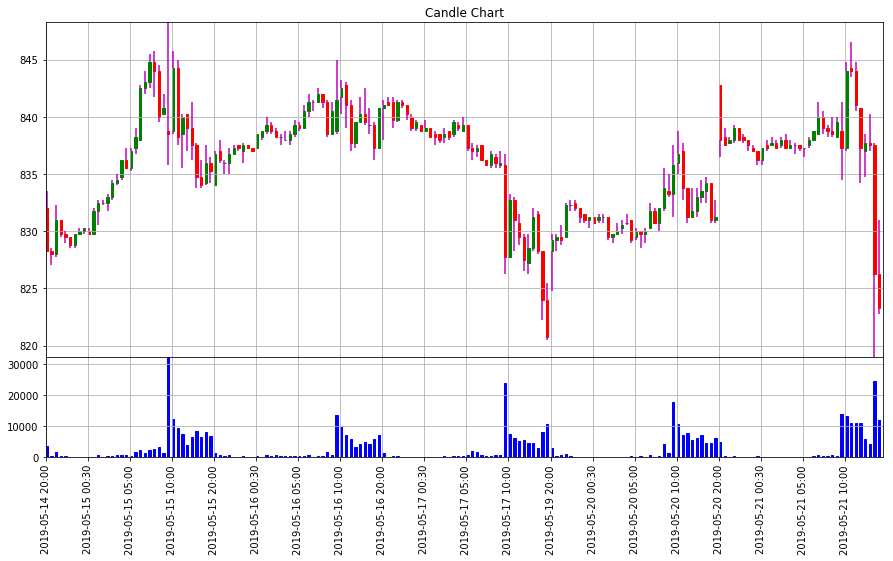

In [21]:
from itertools import groupby
# set the number of daily days to print on each iteration
days_to_print=5

def divby(val):
    return math.floor(val/days_to_print)

df = pd.read_csv(f'{SAVE_BASE}/{co}/{fnames[-1]}')
df_rescaled_daily = scale_daily(df=df,hhmm_for_open='0930')
all_days_indice_groups = [list(it) for k, it in groupby(list(range(len(df_rescaled_daily))), divby)] 
df_rescaled_intra = scale_intraday(df,minute_scale=30)
# pu.candles(date_column='dt',df=df_rescaled_daily,date_offset_to_show=(0,10),title=fname)
for ad in all_days_indice_groups:
    tds = df_rescaled_daily.iloc[ad].trade_date.values
    df_rescaled_daily_partial = df_rescaled_daily[df_rescaled_daily.trade_date.isin(tds)]
    try:
        pu.candles(date_column='dt',df=df_rescaled_daily_partial,date_offset_to_show=(0,10),title=fname)
    except:
        pass
    plt.figure()
    df_rescaled_intra_partial = df_rescaled_intra[df_rescaled_intra.trade_date.isin(tds)]
    pu.candles(date_column='dt',df=df_rescaled_intra_partial,date_offset_to_show=(0,16))
                                                  
                                                  
                                                  

### Print daily data for all contracts of commodities in fnames

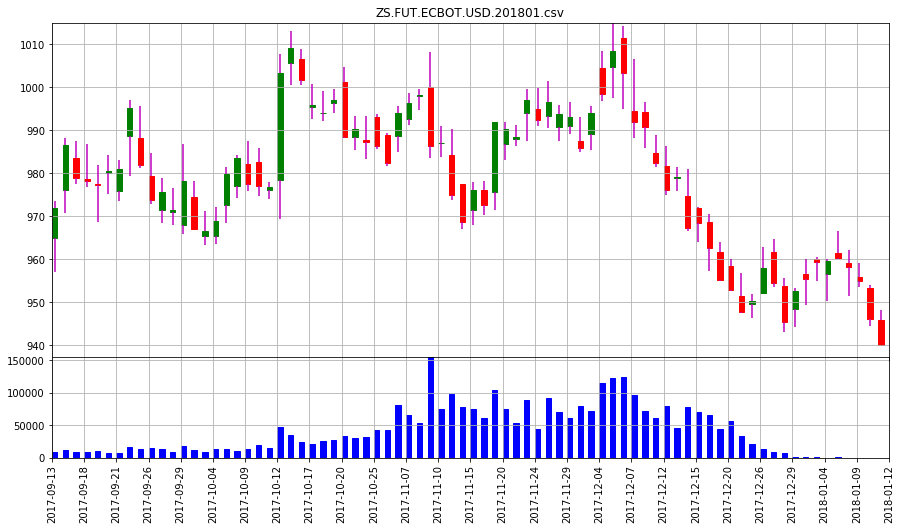

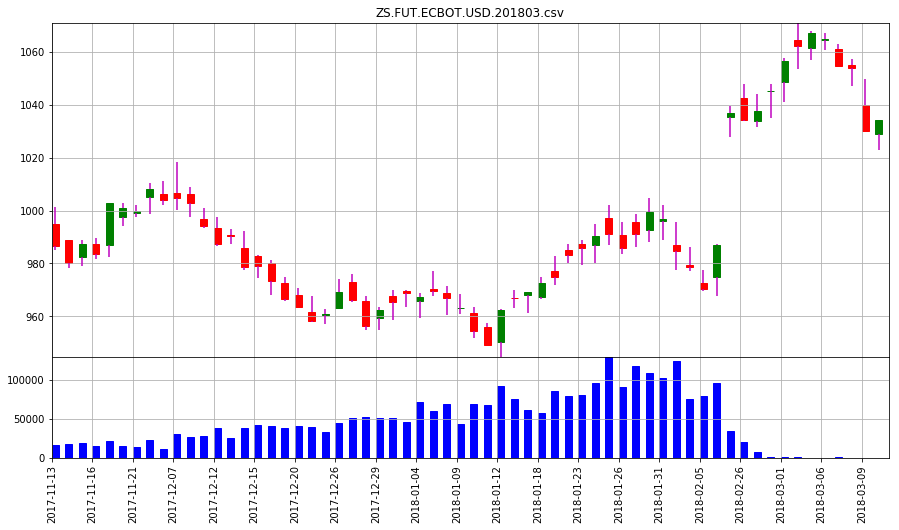

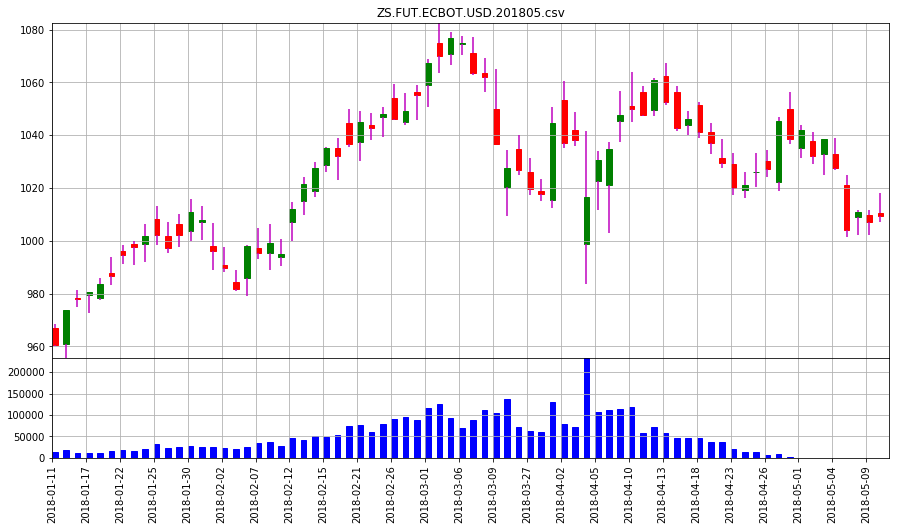

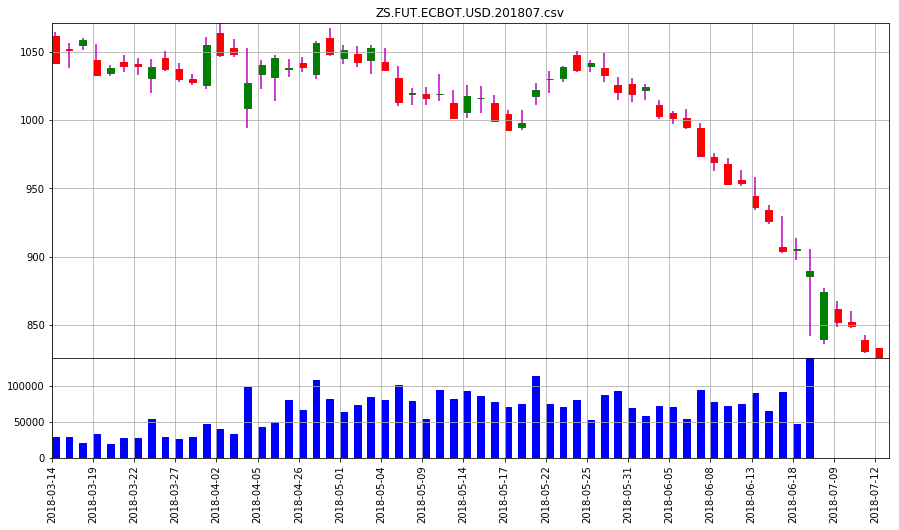

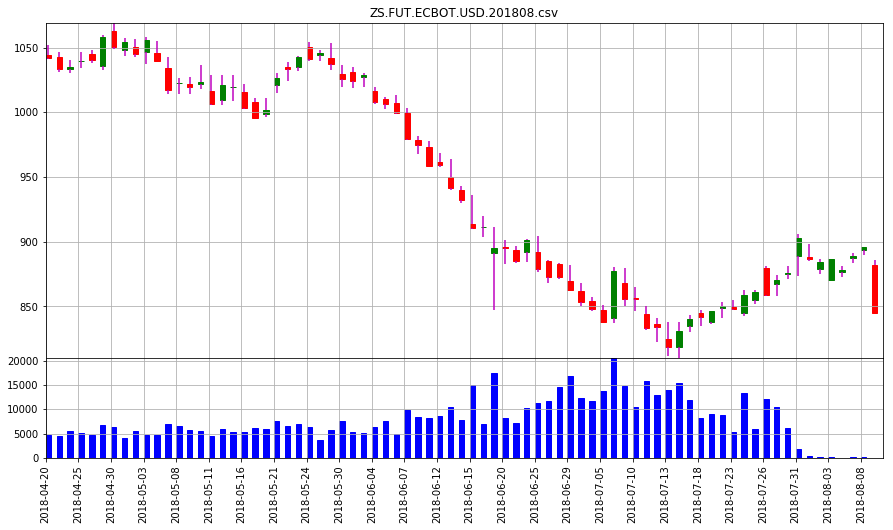

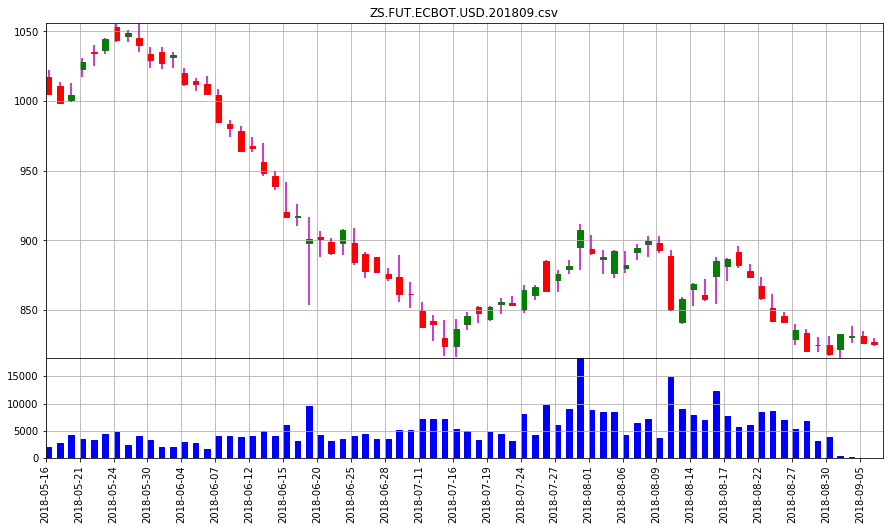

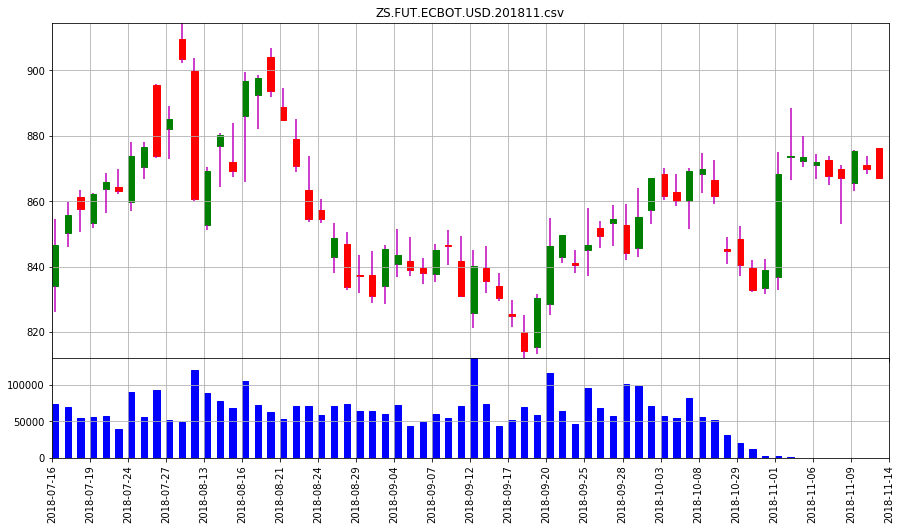

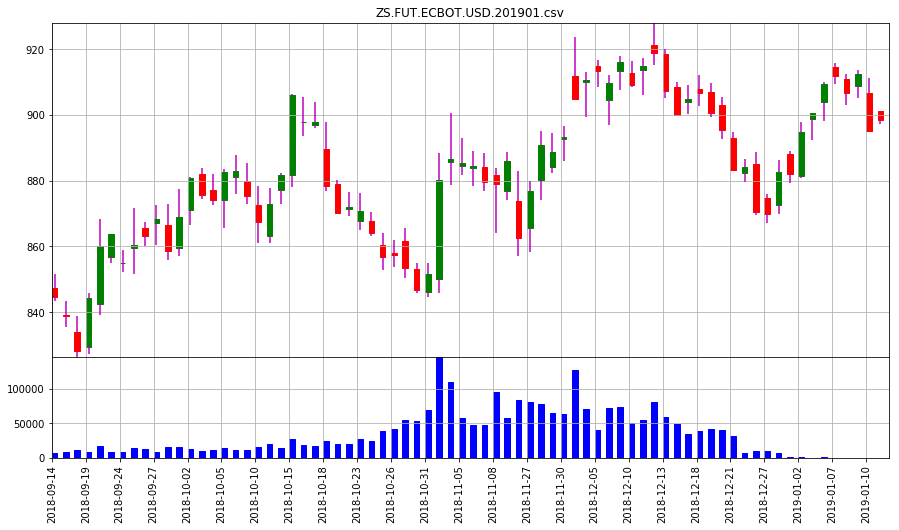

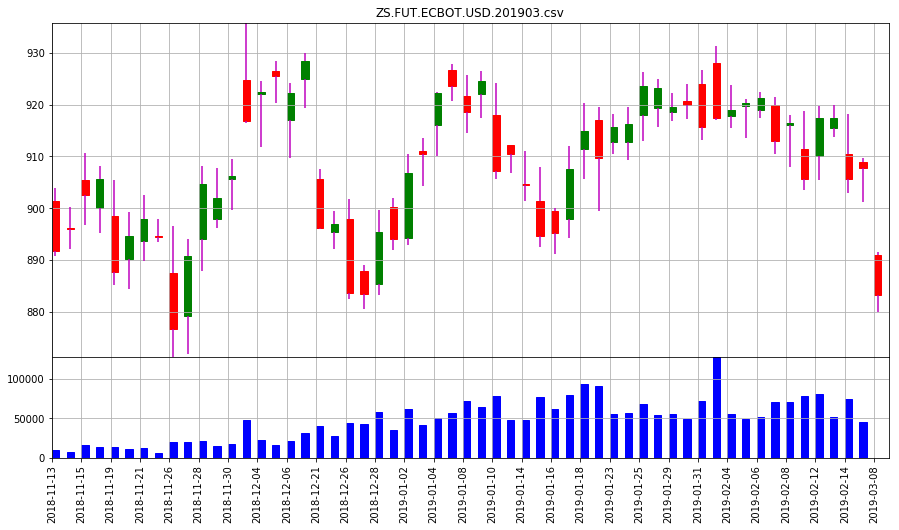

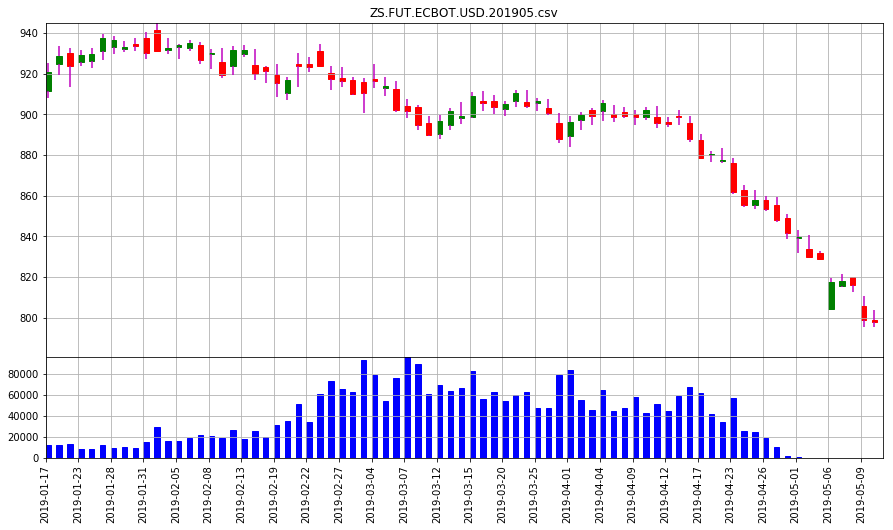

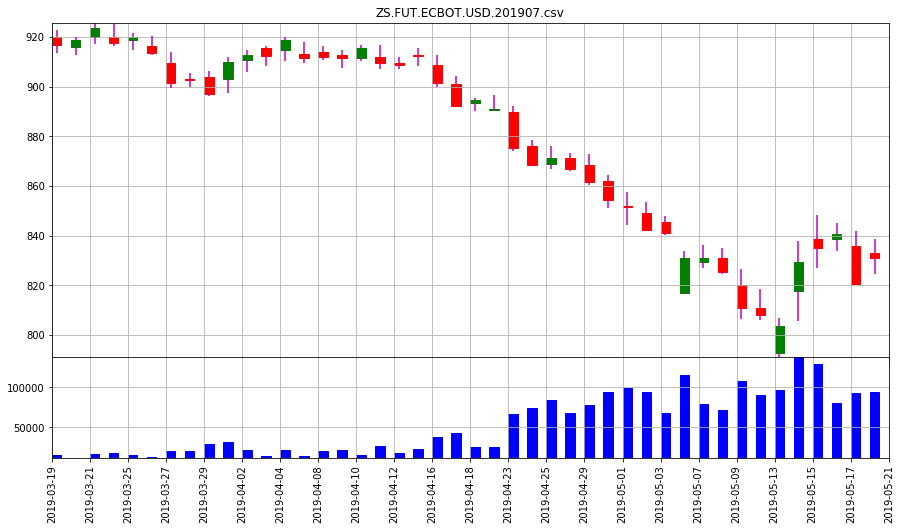

In [22]:
for fname in fnames:
    df = pd.read_csv(f'{SAVE_BASE}/{co}/{fname}')
    df_rescaled_daily = scale_daily(df,'0930')
    pu.candles(date_column='dt',df=df_rescaled_daily,date_offset_to_show=(0,10),title=fname)
#     all_days = df_rescaled_daily.dt
#     all_days_indice_groups = [list(it) for k, it in groupby(list(range(len(all_days))), divby)] 
#     df_rescaled_intra = scale_intraday(df,minute_scale=30)
#     pu.candles(date_column='dt',df=df_rescaled_intra,date_offset_to_show=(0,16))
    

### Show bar graph of daily % changes, and a moving average of them as well

In [23]:

for fname in fnames:
    df = pd.read_csv(f'{SAVE_BASE}/{co}/{fname}')
    df_rescaled_daily = scale_daily(df,'0930')
    df_rescaled_daily['chg'] = df_rescaled_daily.close.pct_change()
    df_rescaled_daily['roll_mean'] = df_rescaled_daily.chg.rolling(5).mean()
    iplot(pu.plotly_bar_plot(df_in=df_rescaled_daily[['dt','chg','roll_mean']],x_column='dt',plot_title=fname))
